# [Deep FM](https://velog.io/@ooooo_h/Paper-Review-2017-Huifeng-Guo-DeepFM-A-Factorization-Machine-based-Neural-Network-for-CTR-Prediction)

- `Factorization Machine (FM)`:    
low-order interaction(낮은 차원의 상호관계)뿐만 아니라 high-order interaction(높은 차원의 상호관계)도 이론상으로 모델링이 가능하다. 하지만 후자까지 고려할 경우 모델의 complexity가 너무 커져 사실상 사용하기 어렵다.  
- `Factorization Machine supported Neural Network (FNN)`:    
NN 기반으로 high-order interaction은 모델링이 가능하다. 하지만 low-order를 제대로 포착하기 어렵고 pre-train FM을 사용하기 때문에 이것의 성능이 모델 전체의 성능을 좌우하게 되는 단점이 있다.  

`Deep FM`은 low-order interaction와 high-order feature interaction을 모두 포착할 수 있는 모델이다.



## CTR (Click-Through Rate)

> 클릭률(CTR)은 광고를 본 사용자가 해당 광고를 클릭하는 빈도의 비율이다. 클릭률(CTR)을 사용하면 키워드와 광고, 무료 제품 목록의 실적을 파악할 수 있다.   
> CTR = 클릭수 / 노출수

추천 시스템에서 CTR을 최대화 하기 위해서는 유저 행동에 숨겨진 복잡한 상호관계(feature interaction)을 학습하는 것이 중요하다.  

### Click - Through Rate Prediction for recommendation
- CTR Prediction은 User가 추천 아이템을 클릭할 확률을 추정하는 것으로 유저에게 추천될 아이템의 순위를 매길 수 있다. 또한 온라인 광고 같은 시나리오에서도 수입을 증가시킬 수 있다.
- CTR Prediction은 User click 행동에 존재하는 implicit feature interactions를 학습하는 것이 중요하다. 
- 일반적으로 User click 행동의 interactions는 매우 복잡하고 low-order, high-order interaction이 중요한 역할을 한다.   

> Example
> 1. 식사시간에 배달앱 다운로드 하는 경우 많음 ->   
"app category"와 "time-stamp"의 interaction (`order-2`)
> 2. 10대 남자들은 Shooting games & RPG games 좋아함 ->    
"app category", "gender", "age"의 interaction (`order-3`)   

예시와 같이 쉽게 어떠한 feature interactions는 이해할 수 있지만, 대부분의 feature interactions는 데이터 속에 숨겨져 있어서 알기 어렵다.

## Training Dataset
- y(target):   
1(user clicked the item), 0(otherwise). 
- x(features):   
  - Categorical fields(e.g., gender): one-hot encoding
  - Continuous fields(e.g., age): value, one-hot encoding

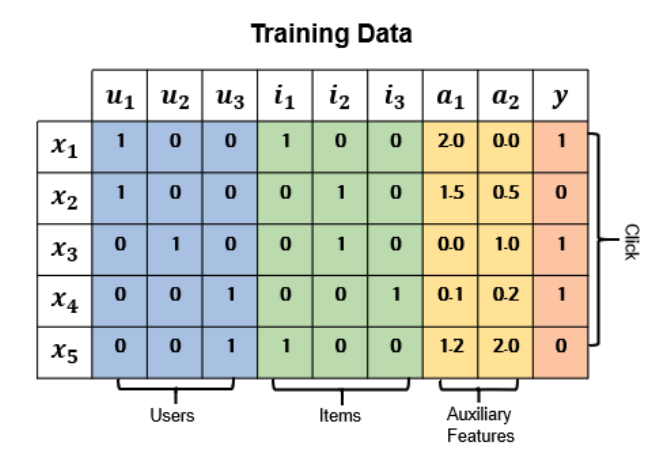

## Model Structure

- Factorization Machines(FM)과 Deep Neural Network(DNN)의 구조를 결합한 새로운 NN 모델이다. 
- Wide & Deep 모델과 다르게 같은 input, embedding layer를 공유하기 때문에 효율적으로 학습할 수 있다.  
- Benchmark data와 commercial data에 평가한 결과 다른 CTR Rrediction 모델보다 일관적으로 향상된 결과를 보였다.

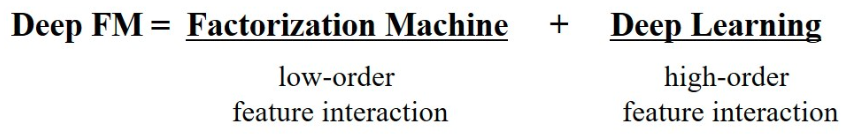

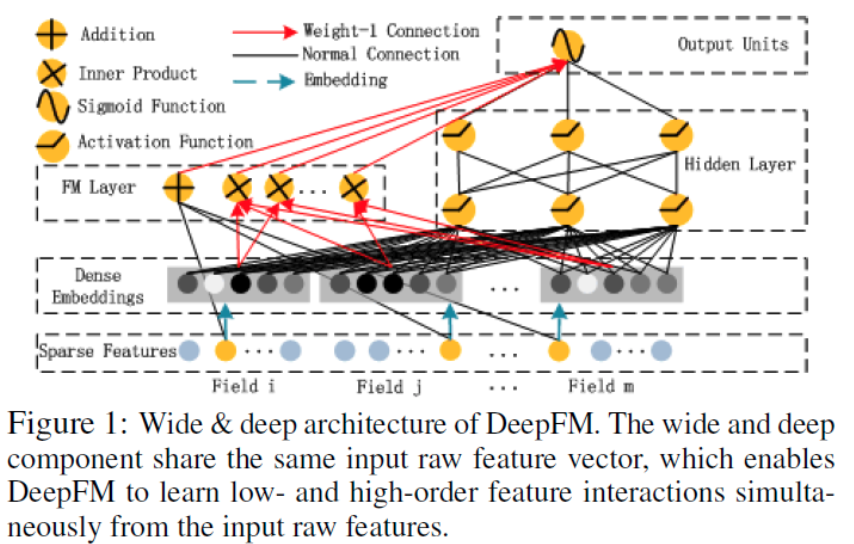

### Dense Embeddings
FM Component와 Deep Componet가 같은 Embedding 벡터를 공유한다. 이러한 구조는 두 가지 정점을 가진다.   

1. Field vector의 크기가 다를 수 있지만 Embedding Layer로 인해 같은 크기(k=5)를 가진다.  
  > Genger의 경우 크기가 2인 vector이지만 국적이나 나이의 경우 Gender보다 더 큰 벡터를 가지게 된다. 하지만 결과적으로 k-dimension으로 Embedding된다.  
2. pre-trained할 필요가 없고 End-to-End로 학습을 할 수 있다.

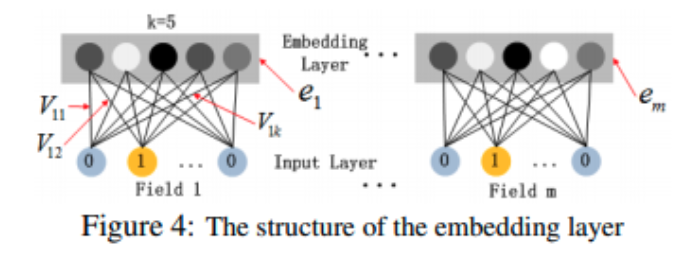

### FM Component
- FM Component는 feature interaction을 학습하기 위한 Factorization machines이다.  
- FM은 각각 feature latent vector의 inner product (order-2)로 feature interaction을 모델링한다.  
- FM의 Output은 Addition Unit과 Inner Product Unit의 합으로 표현된다.

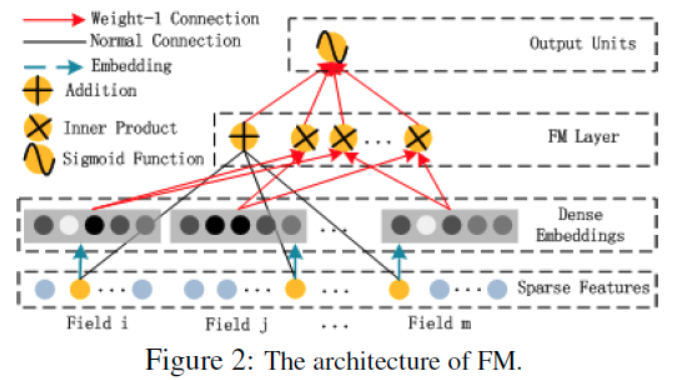

### Deep Component
- Deep Component는 high-order feature interaction을 학습하기 위한 Feed-Forward Neural Network이다.  
- CTR prediction 모델의 Input data는 굉장히 Sparse하고 super high-demensional하다.  
  - Embedding layer를 통해 Input vector를 low-order dense한 vector로 압축되어 NN에 입력된다.

# [코드](https://github.com/rixwew/pytorch-fm/blob/master/examples/main.py)

In [1]:
from google.colab import drive
drive.mount('/content/data')

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


In [2]:
import numpy as np 
import pandas as pd 

import easydict
import json

args = easydict.EasyDict()
args.default_path = '/content/data/MyDrive/google_lecture/06. deep learning/4. RS Pytorch/data/Movie/ml-1m/'
args.ratings = args.default_path+'ratings.csv'
args.movies_metadata = args.default_path+'movies_metadata.csv'

## Load Data

In [3]:
df_ratings = pd.read_csv(args.ratings, sep=',', engine='c', header='infer')
print(f'{df_ratings.shape}')
df_ratings.head(2)

(100004, 4)


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179


In [4]:
df_ratings.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


In [5]:
df_meta = pd.read_csv(args.movies_metadata, low_memory=False)
print(f'{df_meta.shape}')
df_meta.head(2)

(45466, 24)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


## Data Preprocessing

### Merge

In [6]:
df_meta = df_meta.rename(columns={'id':'movieId'}) # movie_id
df_ratings['movieId'] = df_ratings['movieId'].astype(str)
df_meta['movieId'] = df_meta['movieId'].astype(str)

df_ratings = pd.merge(df_ratings, df_meta[['movieId', 'original_title']], how='left', on='movieId')

print(f'{df_ratings.shape}')
df_ratings.head(2)

(100009, 5)


,userId,movieId,rating,timestamp,original_title
0,1,31,2.5,1260759144,NaN
1,1,1029,3.0,1260759179,NaN


### isnull 처리 

In [7]:
(df_ratings.isnull().sum() / df_ratings.shape[0]).round(4).sort_values(ascending=False) # 각 걸럼별 결측치 비율

original_title    0.5501
userId            0.0000
movieId           0.0000
rating            0.0000
timestamp         0.0000
dtype: float64

In [8]:
df_ratings = df_ratings[df_ratings['original_title'].notnull()].reset_index(drop=True)

(df_ratings.isnull().sum() / df_ratings.shape[0]).round(4).sort_values(ascending=False) # 각 걸럼별 결측치 비율

userId            0.0
movieId           0.0
rating            0.0
timestamp         0.0
original_title    0.0
dtype: float64

### create new id

In [9]:
df_title = df_ratings[['original_title']].drop_duplicates().reindex()
df_title['title_id'] = np.arange(len(df_title))

df_ratings = pd.merge(df_ratings, df_title, on=['original_title'], how='left')
print(df_ratings.shape)
df_ratings.head(2)

(44994, 6)


,userId,movieId,rating,timestamp,original_title,title_id
0,1,1371,2.5,1260759135,Rocky III,0
1,1,1405,1.0,1260759203,Greed,1


In [10]:
df_user = df_ratings[['userId']].drop_duplicates().reindex()
df_user['user_id'] = np.arange(len(df_user))

df_ratings = pd.merge(df_ratings, df_user, on=['userId'], how='left')
print(df_ratings.shape)
df_ratings.head(2)

(44994, 7)


,userId,movieId,rating,timestamp,original_title,title_id,user_id
0,1,1371,2.5,1260759135,Rocky III,0,0
1,1,1405,1.0,1260759203,Greed,1,0


In [11]:
df_movie = df_ratings[['movieId']].drop_duplicates().reindex()
df_movie['movie_id'] = np.arange(len(df_movie))

df_ratings = pd.merge(df_ratings, df_movie, on=['movieId'], how='left')
print(df_ratings.shape)
df_ratings.head(2)

(44994, 8)


,userId,movieId,rating,timestamp,original_title,title_id,user_id,movie_id
0,1,1371,2.5,1260759135,Rocky III,0,0,0
1,1,1405,1.0,1260759203,Greed,1,0,1


In [12]:
df_ratings = df_ratings[['user_id', 'movie_id', 'title_id', 'rating']]
print(df_ratings.shape)
df_ratings.head(2)

(44994, 4)


,user_id,movie_id,title_id,rating
0,0,0,0,2.5
1,0,1,1,1.0


## Dataset

In [13]:
import torch.utils.data

class MovieLens1MDataset(torch.utils.data.Dataset):
    """
    MovieLens 1M Dataset
    Data preparation
        treat samples with a rating less than 3 as negative samples
    :param dataset_path: MovieLens dataset path
    Reference:
        https://grouplens.org/datasets/movielens
    """

    def __init__(self, df, sep=','):
        # data = pd.read_csv(dataset_path, sep=sep).to_numpy()[:, :3]
        data = df.to_numpy()
        self.items = data[:, :3].astype(np.int)
        self.targets = self.__preprocess_target(data[:, 3]).astype(np.float32)
        self.field_dims = np.max(self.items, axis=0) + 1
        # self.user_field_idx = np.array((0, ), dtype=np.long)
        # self.item_field_idx = np.array((1,), dtype=np.long)

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, index):
        return self.items[index], self.targets[index]

    def __preprocess_target(self, target):
        target[target <= 3] = 0
        target[target > 3] = 1
        return target

In [14]:
dataset = MovieLens1MDataset(df_ratings)
print(f'{len(dataset)} / {dataset.field_dims}')

44994 / [ 671 2830 2798]


<ipython-input-13-3cd223d69c38>:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.items = data[:, :3].astype(np.int)


## DataLoader

In [15]:
from torch.utils.data import DataLoader

data_loader = DataLoader(dataset, batch_size=10)

In [16]:
features, target = next(iter(data_loader))

features.shape, target.shape

(torch.Size([10, 3]), torch.Size([10]))

## Model

In [17]:
import numpy as np
import torch
import torch.nn.functional as F

### Layers

In [18]:
class FeaturesLinear(torch.nn.Module):

    def __init__(self, field_dims, output_dim=1):
        super().__init__()
        self.embedding = torch.nn.Embedding(sum(field_dims), output_dim)
        self.bias = torch.nn.Parameter(torch.zeros((output_dim,)))
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.float64)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        return torch.sum(self.embedding(x), dim=1) + self.bias

- 디버깅

In [19]:
field_dims = dataset.field_dims
field_dims

array([ 671, 2830, 2798])

In [20]:
embedding = torch.nn.Embedding(sum(field_dims), 1)
bias = torch.nn.Parameter(torch.zeros((1,)))
offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.float64)

In [21]:
bias

Parameter containing:
tensor([0.], requires_grad=True)

In [22]:
offsets

array([   0.,  671., 3501.])

In [23]:
features, target = next(iter(data_loader))

features.shape, target.shape # (batch_size, features_size)

(torch.Size([10, 3]), torch.Size([10]))

In [24]:
fl_input = features + features.new_tensor(offsets).unsqueeze(0)
fl_input.shape # (batch_size, features_size)

torch.Size([10, 3])

In [25]:
fl_out = torch.sum(embedding(fl_input), dim=1) + bias
fl_out.shape 

torch.Size([10, 1])

In [26]:
class FeaturesEmbedding(torch.nn.Module):

    def __init__(self, field_dims, embed_dim):
        super().__init__()
        self.embedding = torch.nn.Embedding(sum(field_dims), embed_dim)
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.float64)
        torch.nn.init.xavier_uniform_(self.embedding.weight.data)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        return self.embedding(x)

- 디버깅 

In [27]:
embedding = torch.nn.Embedding(sum(field_dims), 16)
offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.float64)

In [28]:
offsets

array([   0.,  671., 3501.])

In [29]:
features.shape 

torch.Size([10, 3])

In [30]:
embedding_input = features + features.new_tensor(offsets).unsqueeze(0)
embedding_input.shape 

torch.Size([10, 3])

In [31]:
embedding_out = embedding(embedding_input)
embedding_out.shape # (batch_size, features_size, embedding_size)

torch.Size([10, 3, 16])

In [32]:
class FactorizationMachine(torch.nn.Module):

    def __init__(self, reduce_sum=True):
        super().__init__()
        self.reduce_sum = reduce_sum

    def forward(self, x): # (batch_size, features_size, embedding_size)
        """
        :param x: Float tensor of size ``(batch_size, num_fields, embed_dim)``
        """
        square_of_sum = torch.sum(x, dim=1) ** 2
        sum_of_square = torch.sum(x ** 2, dim=1)
        ix = square_of_sum - sum_of_square
        if self.reduce_sum:
            ix = torch.sum(ix, dim=1, keepdim=True)
        return 0.5 * ix

- 디버깅 

In [33]:
square_of_sum = torch.sum(embedding_out, dim=1) ** 2
square_of_sum.shape # (batch_size, embedding_size)

torch.Size([10, 16])

In [34]:
sum_of_square = torch.sum(embedding_out ** 2, dim=1)
sum_of_square.shape # (batch_size, embedding_size) 

torch.Size([10, 16])

In [35]:
ix = square_of_sum - sum_of_square
ix.shape  # (batch_size, embedding_size)

torch.Size([10, 16])

In [36]:
ix = torch.sum(ix, dim=1, keepdim=True)
ix.shape # (batch_size, 1)

torch.Size([10, 1])

In [37]:
fm_out = 0.5 * ix
fm_out.shape # (batch_size, 1)

torch.Size([10, 1])

In [38]:
class MultiLayerPerceptron(torch.nn.Module):

    def __init__(self, input_dim, embed_dims, dropout, output_layer=True):
        super().__init__()
        layers = list()
        for embed_dim in embed_dims:
            layers.append(torch.nn.Linear(input_dim, embed_dim))
            layers.append(torch.nn.BatchNorm1d(embed_dim))
            layers.append(torch.nn.ReLU())
            layers.append(torch.nn.Dropout(p=dropout))
            input_dim = embed_dim
        if output_layer:
            layers.append(torch.nn.Linear(input_dim, 1))
        self.mlp = torch.nn.Sequential(*layers)

    def forward(self, x):
        """
        :param x: Float tensor of size ``(batch_size, embed_dim)``
        """
        return self.mlp(x)

- 디버깅 

In [39]:
input_dim = len(field_dims) * 16 #embed_dim
input_dim

48

In [40]:
layers = list()
for embed_dim in (16, 16):
    layers.append(torch.nn.Linear(input_dim, embed_dim))
    layers.append(torch.nn.BatchNorm1d(embed_dim))
    layers.append(torch.nn.ReLU())
    layers.append(torch.nn.Dropout(p=0.2))
    input_dim = embed_dim

layers.append(torch.nn.Linear(input_dim, 1))
mlp = torch.nn.Sequential(*layers)

In [41]:
input_dim = len(field_dims) * 16 #embed_dim
input_dim

48

In [42]:
mlp_input = embedding_out.view(-1, input_dim)
mlp_input.shape 

torch.Size([10, 48])

In [43]:
mlp_out = mlp(mlp_input)
mlp_out.shape 

torch.Size([10, 1])

### Deep FM

In [44]:
class DeepFactorizationMachineModel(torch.nn.Module):
    """
    A pytorch implementation of DeepFM.
    Reference:
        H Guo, et al. DeepFM: A Factorization-Machine based Neural Network for CTR Prediction, 2017.
    """

    def __init__(self, field_dims, embed_dim, mlp_dims, dropout):
        super().__init__()
        self.linear = FeaturesLinear(field_dims)
        self.fm = FactorizationMachine(reduce_sum=True)
        self.embedding = FeaturesEmbedding(field_dims, embed_dim)
        self.embed_output_dim = len(field_dims) * embed_dim
        self.mlp = MultiLayerPerceptron(self.embed_output_dim, mlp_dims, dropout)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        embed_x = self.embedding(x) # (batch_size, feature_size, embedding_size)
        x = self.linear(x) + self.fm(embed_x) + self.mlp(embed_x.view(-1, self.embed_output_dim)) 
        return torch.sigmoid(x.squeeze(1))

In [45]:
field_dims = dataset.field_dims
embed_dim=16
mlp_dims=(16, 16)
dropout=0.2
embed_output_dim = len(field_dims) * embed_dim

In [46]:
linear = FeaturesLinear(field_dims)
fm = FactorizationMachine(reduce_sum=True)
embedding = FeaturesEmbedding(field_dims, embed_dim)
mlp = MultiLayerPerceptron(embed_output_dim, mlp_dims, dropout)

In [47]:
features, target = next(iter(data_loader))

features.shape, target.shape 

(torch.Size([10, 3]), torch.Size([10]))

In [48]:
embed_out = embedding(features)
embed_out.shape

torch.Size([10, 3, 16])

In [49]:
linear_out = linear(features)
linear_out.shape

torch.Size([10, 1])

In [50]:
fm_out = fm(embed_out)
fm_out.shape

torch.Size([10, 1])

In [51]:
mlp_out = mlp(embed_out.view(-1, embed_output_dim))
mlp_out.shape

torch.Size([10, 1])

In [52]:
out = linear_out + fm_out + mlp_out 
out.shape

torch.Size([10, 1])

In [53]:
out.squeeze(1).shape

torch.Size([10])

In [54]:
torch.sigmoid(out.squeeze(1)).shape

torch.Size([10])

## Engine

### EarlyStopper

In [55]:
class EarlyStopper(object):

    def __init__(self, num_trials, save_path):
        self.num_trials = num_trials
        self.trial_counter = 0
        self.best_accuracy = 0
        self.save_path = save_path

    def is_continuable(self, model, accuracy):
        if accuracy > self.best_accuracy: # 현재 정확도가 최고 정확도보다 더 높은 경우 
            self.best_accuracy = accuracy # 최고 정확도를 현재 정확도로 업데이트 
            self.trial_counter = 0 # 초기화 
            torch.save(model, self.save_path) # 최고 정확도를 갖은 모델 저장 
            return True
        elif self.trial_counter + 1 < self.num_trials: # 현재 정확도가 최고 정확도보다 작은 경우 & max 시도횟수보다 현재 시도횟수가 작은 경우 
            self.trial_counter += 1 # 기존 시도횟수 + 1 
            return True
        else: # 현재 정확도가 최고 정확도보다 작은 경우 & 현재 시도횟수가 max 시도횟수보다 큰 경우 
            return False

### Train Step

In [56]:
from tqdm.auto import tqdm

def train_step(model, optimizer, data_loader, criterion, device, log_interval=100):
    model.train()
    total_loss = 0
    tk0 = tqdm(data_loader, smoothing=0, mininterval=1.0)
    for i, (fields, target) in enumerate(tk0):
        fields, target = fields.to(device), target.to(device)
        y = model(fields)
        loss = criterion(y, target.float())
        model.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if (i + 1) % log_interval == 0:
            tk0.set_postfix(loss=total_loss / log_interval)
            total_loss = 0

### Test Step

In [57]:
from sklearn.metrics import roc_auc_score

def test_step(model, data_loader, device):
    model.eval()
    targets, predicts = list(), list()
    with torch.no_grad():
        for fields, target in tqdm(data_loader, smoothing=0, mininterval=1.0):
            fields, target = fields.to(device), target.to(device)
            y = model(fields)
            targets.extend(target.tolist())
            predicts.extend(y.tolist())
    return roc_auc_score(targets, predicts)

## Main

In [58]:
def main(dataset,
         model_name,
         epoch,
         learning_rate,
         batch_size,
         weight_decay,
         device,
         save_dir):
    device = torch.device(device)
    train_length = int(len(dataset) * 0.8)
    valid_length = int(len(dataset) * 0.1)
    test_length = len(dataset) - train_length - valid_length

    train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
        dataset, (train_length, valid_length, test_length))
    
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size)
    valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size)
    test_data_loader = DataLoader(test_dataset, batch_size=batch_size)

    model = DeepFactorizationMachineModel(dataset.field_dims, embed_dim=16, mlp_dims=(16, 16), dropout=0.2).to(device)

    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    early_stopper = EarlyStopper(num_trials=2, save_path=f'{save_dir}/{model_name}.pt')

    for epoch_i in range(epoch):
        train_step(model, optimizer, train_data_loader, criterion, device)
        auc = test_step(model, valid_data_loader, device)
        print('epoch:', epoch_i, 'validation: auc:', auc)
        if not early_stopper.is_continuable(model, auc):
            print(f'validation: best auc: {early_stopper.best_accuracy}')
            break
    
    # best model
    best_model = torch.load(early_stopper.save_path).to(device)
    auc = test_step(best_model, test_data_loader, device)
    print(f'test auc: {auc}')

In [59]:
import os

args.model_name = 'deepfm'
args.epoch = 100
args.learning_rate = 0.001
args.batch_size = 2048
args.weight_decay = 1e-6
args.device = "cuda" if torch.cuda.is_available() else "cpu"
args.save_dir = "models"

if not os.path.exists(args.save_dir):
        os.makedirs(args.save_dir)

dataset = MovieLens1MDataset(df_ratings)
main(dataset,
         args.model_name,
         args.epoch,
         args.learning_rate,
         args.batch_size,
         args.weight_decay,
         args.device,
         args.save_dir)

<ipython-input-13-3cd223d69c38>:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.items = data[:, :3].astype(np.int)


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 0 validation: auc: 0.49940046314222264


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 1 validation: auc: 0.5075514581652341


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 2 validation: auc: 0.5271875392925631


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 3 validation: auc: 0.5942733196938699


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 4 validation: auc: 0.7012026959174038


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 5 validation: auc: 0.7342309316053348


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 6 validation: auc: 0.7419956625173719


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 7 validation: auc: 0.7441414007679068


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 8 validation: auc: 0.7477021917235602


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 9 validation: auc: 0.7503176712656139


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 10 validation: auc: 0.750141765486162


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 11 validation: auc: 0.7507017495651276


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 12 validation: auc: 0.7510196290032616


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 13 validation: auc: 0.7496446495082549


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 14 validation: auc: 0.748431628233856
validation: best auc: 0.7510196290032616


  0%|          | 0/3 [00:00<?, ?it/s]

test auc: 0.7425640392938839
